# PROJET MACH_BDA_DATAVIZ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [2]:
dataset = load_dataset("d0r1h/customer_churn")

df = pd.DataFrame(dataset['train'])

df_reset = df # copie pour ne pas recharger tout le dataset

In [3]:
def reset_dataframe():
    return df_reset

In [4]:
df.iloc[0]

age                                                   18
gender                                                 F
security_no                                      XW0DQ7H
region_category                                  Village
membership_category                  Platinum Membership
joining_date                                  17-08-2017
joined_through_referral                               No
referral_id                                     xxxxxxxx
preferred_offer_types              Gift Vouchers/Coupons
medium_of_operation                                    ?
internet_option                                    Wi-Fi
last_visit_time                                 16:08:02
days_since_last_login                                 17
avg_time_spent                                    300.63
avg_transaction_value                           53005.25
avg_frequency_login_days                              17
points_in_wallet                                  781.75
used_special_discount          

## Traitement des Données

In [5]:
df.isnull().sum()

age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [6]:
def clean_dataframe(df):
    df.dropna(inplace=True)
    df.drop(columns=['security_no', 'referral_id'],inplace=True)
    
    df['medium_of_operation'] = df['medium_of_operation'].replace('?', 'Unknown')
    
    df = df[df['days_since_last_login'] > 0]
    df = df[df['avg_time_spent'] > 0]
    df = df[df['points_in_wallet'] > 0]
    
    df['joining_date'] = pd.to_datetime(df['joining_date'], format='%d-%m-%Y')
    df['last_visit_time'] = pd.to_datetime(df['last_visit_time'], format='%H:%M:%S').dt.time

    df['joining_year'] = df['joining_date'].dt.year
    df['joining_month'] = df['joining_date'].dt.month
    df['joining_day'] = df['joining_date'].dt.day

    df['last_visit_hour'] = df['last_visit_time'].apply(lambda x: x.hour)
    df['last_visit_minute'] = df['last_visit_time'].apply(lambda x: x.minute)

    df.drop(columns=['joining_date', 'last_visit_time'], inplace=True)
    
    return df

Standardisation des données numériques (mettre toutes les valeurs entre 0 et 1, pas sûr s'il y a vraiment besoin):

In [7]:
def normalize_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_columns] = MinMaxScaler().fit_transform(df[numeric_columns])
    return df

Encodage des données non numériques:

In [8]:
def encode_columns(df, binary_columns):
    non_numeric_columns = df.select_dtypes(include=['object']).columns
    one_hot_encoder_cols = [col for col in non_numeric_columns if col not in binary_columns]

    for col in binary_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    ct = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(), one_hot_encoder_cols)
    ], remainder='passthrough')

    df_encoded = ct.fit_transform(df)
    
    onehot_feature_names = ct.named_transformers_['onehot'].get_feature_names_out(one_hot_encoder_cols)
    all_feature_names = list(onehot_feature_names) + [col for col in df.columns if col not in one_hot_encoder_cols]
    
    encoded_df = pd.DataFrame(df_encoded, columns=all_feature_names)
    
    return encoded_df

In [9]:
df = clean_dataframe(df)
# encoded_df = encode_columns(df, binary_columns=['gender', 'joined_through_referral', 'used_special_discount', 'offer_application_preference', 'past_complaint'])

Je n'ai pas encore reussi a encoder les colonnes non numeriques

## Analyse et visualisation exploratoire des Données

## Evaluation de plusieurs modèles avec les bonnes métriques

In [10]:
df = normalize_numeric_columns(df)
df = df.drop(columns=df.select_dtypes(exclude=['float64', 'int64']).columns)

In [11]:
class PrevisionChurn:
    def __init__(self, model):
        self.model = model
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)

In [12]:
X = df.drop(columns=['churn_risk_score'])
y = df['churn_risk_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'AdaBoost': AdaBoostClassifier(),
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results[model_name] = accuracy

for model_name, accuracy in results.items():
    print(f"{model_name} Accuracy: {accuracy:.2f}")


Logistic Regression Accuracy: 0.70
SVM Accuracy: 0.78
Random Forest Accuracy: 0.88
Gradient Boosting Accuracy: 0.89
KNN Accuracy: 0.64
AdaBoost Accuracy: 0.88


In [13]:
def features_importance(model,coeff_method=None):
    if coeff_method == 'arbres':
        feature_importances = model.feature_importances_
    else:
        feature_importances = model.coef_[0]
    
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    return feature_importance_df

In [14]:
feature_importance_df = features_importance(models['Random Forest'], 'arbres')

## Visualiser et interpreter les résultats

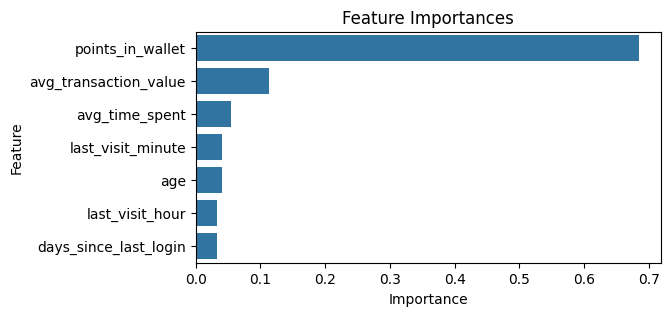

In [15]:
plt.figure(figsize=(6, 3))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()